# Pipeline_GridSearchCV

In [8]:
z

import warnings

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Rozważmy zbiór Breast Cancer

In [9]:
np.random.seed(1)
wine = datasets.load_wine()
# print description
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [10]:
# get the data
X = wine.data
y = wine.target

Podzielmy zbiór na część testową i treningową .

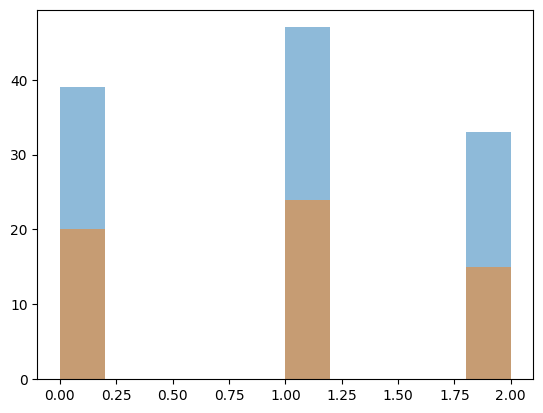

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Skalowanie danych już na początku w celu zmniejszenia czasu trenowania
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

# Zadanie
Znajdż najleprzy model dzieląc na zbiór testowy i terningowy dla 

* SVM z jądrem rbf
* SVM z jądrem poly
* SVM liniowego
* Regresji logistycznej


In [12]:
seed = 123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [13]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

param_grid = {
    'preprocessing': [StandardScaler(), None],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(X_train_scaled, y_train)
grid_1.best_params_

{'classifier__C': 10,
 'classifier__gamma': 0.01,
 'preprocessing': StandardScaler()}

In [14]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array().flatten()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [15]:
# convert to DataFrame
results = pd.DataFrame(grid_1.cv_results_)
# show the first 5 rows
# display(results.head())

In [16]:
len(results.mean_test_score)

72

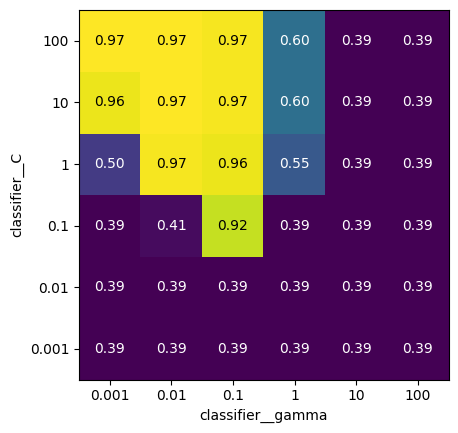

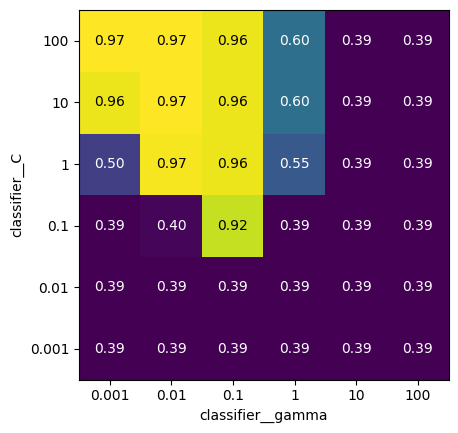

In [17]:
scores = np.array(results.mean_test_score).reshape(6, 6, 2)
scores = scores[:, :, 0]
# plot the mean cross-validation scores
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid['classifier__gamma'], ylabel='classifier__C',
        yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()

scores = np.array(results.mean_test_score).reshape(6, 6, 2)
scores = scores[:, :, 1]
# plot the mean cross-validation scores
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid['classifier__gamma'], ylabel='classifier__C',
        yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()

In [18]:
def grid_fit(pipe, param_grid):
    grid = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)
    grid.fit(X_train_scaled, y_train)

    results = pd.DataFrame(grid.cv_results_)
    scores = np.array(results.mean_test_score).reshape(len(param_grid['classifier__C']),
                                                       len(param_grid.get('classifier__gamma', [1])), 2)

    return scores, grid.best_estimator_

In [19]:
def score_model(model):
    y_pred = model.predict(X_test_scaled)

    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    accuracy = metrics.accuracy_score(y_test, y_pred)

    return precision, recall, f1, accuracy

In [20]:
param_grid_svm = {'preprocessing': [StandardScaler(), None],
                  'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

param_grid_lr = {'preprocessing': [StandardScaler(), None],
                 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}


methods = [
    ("SVM Linear", Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel="linear"))]),
     param_grid_svm),
    ("SVM RBF", Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel="rbf"))])
     , param_grid_svm),
    ("SVM Poly", Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel="poly"))])
     , param_grid_svm),
    ("Logistic Regression", Pipeline([('preprocessing', StandardScaler()), (
        'classifier', LogisticRegression(multi_class="multinomial", solver="saga", max_iter=10_000))]),
     param_grid_lr)
]

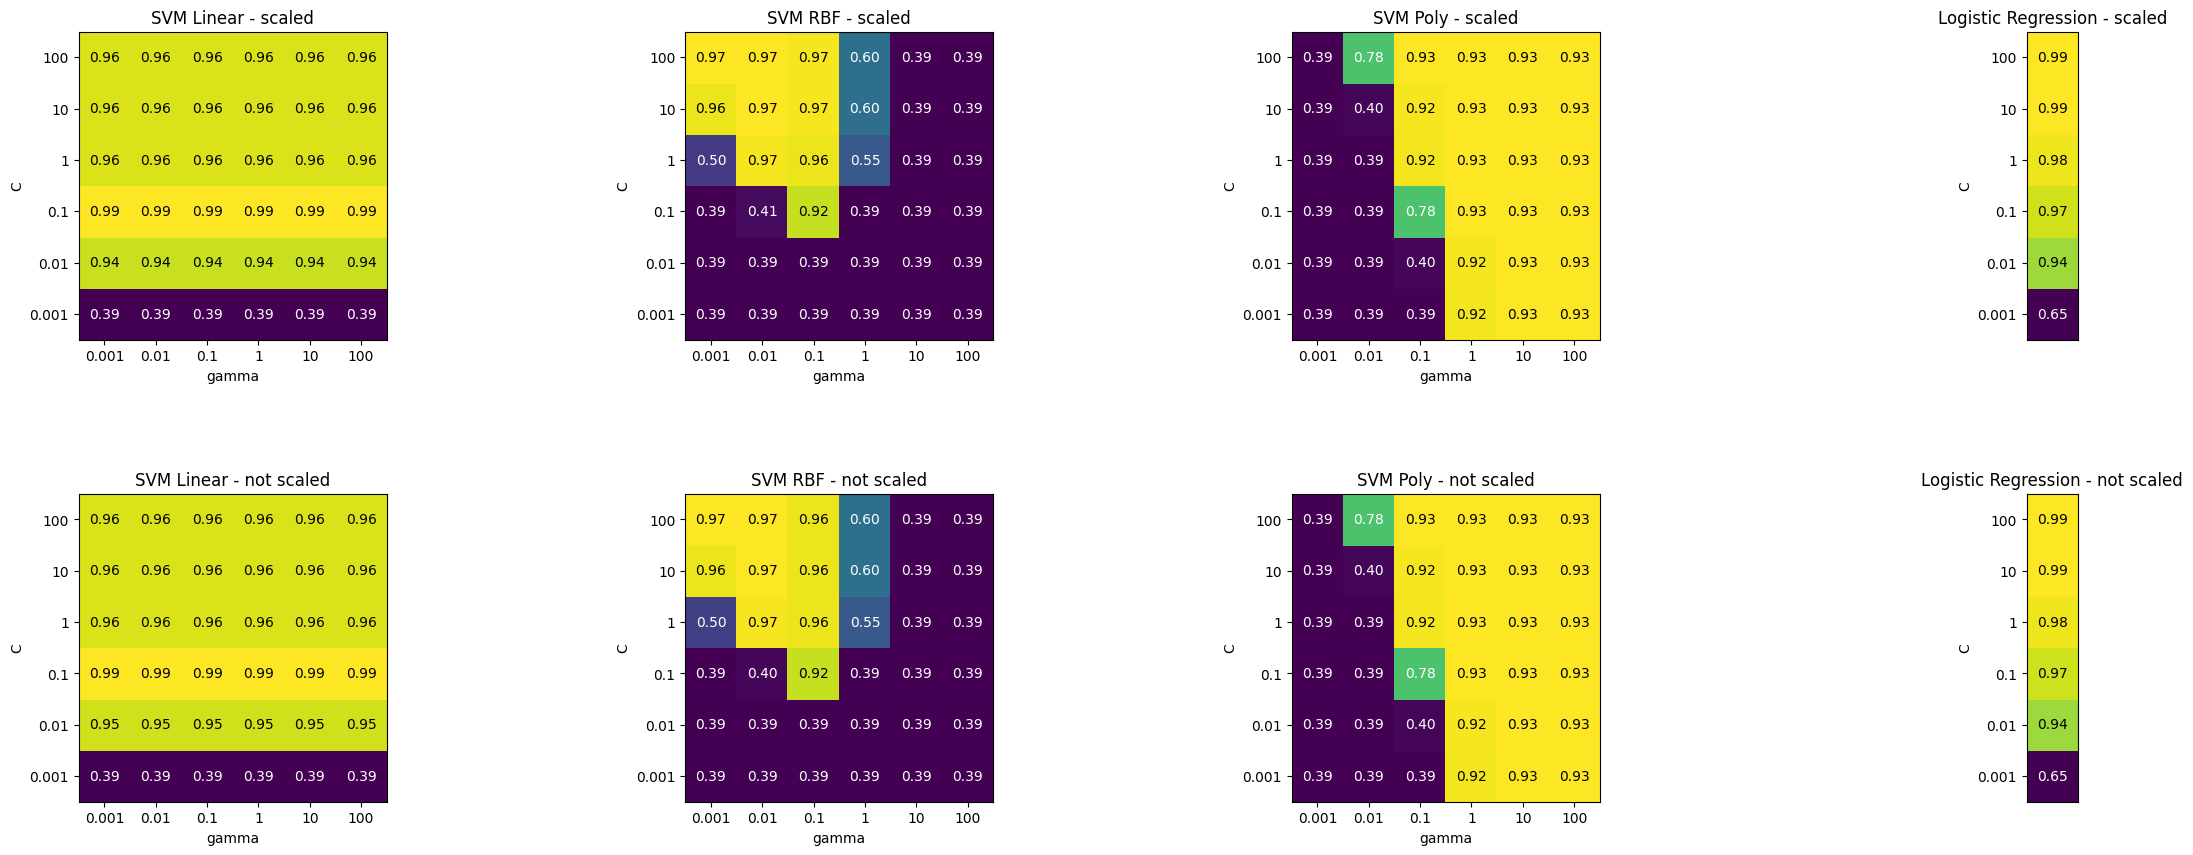

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(30, 10))
plt.subplots_adjust(hspace=0.5)
df = pd.DataFrame(columns=["name", "precision", "recall", "f1", "accuracy"])

for i, (method, pipe, param_grid) in enumerate(methods):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores, best_model = grid_fit(pipe, param_grid)
        precision, recall, f1, accuracy = score_model(best_model)
        df.loc[i] = [method, *score_model(best_model)]

    heatmap(
        scores[:, :, 0],
        xlabel='gamma' if 'classifier__gamma' in param_grid.keys() else "",
        xticklabels=param_grid.get('classifier__gamma', []),
        ylabel="C",
        yticklabels=param_grid.get('classifier__C', []),
        cmap="viridis",
        ax=axs[0, i],
    )
    axs[0, i].set_title(f"{method} - scaled")
    heatmap(
        scores[:, :, 1],
        xlabel='gamma' if 'classifier__gamma' in param_grid.keys() else "",
        xticklabels=param_grid.get('classifier__gamma', []),
        ylabel="C",
        yticklabels=param_grid.get('classifier__C', []),
        cmap="viridis",
        ax=axs[1, i],
    )
    axs[1, i].set_title(f"{method} - not scaled")

plt.show()

In [22]:
df.head()

,name,precision,recall,f1,accuracy
0,SVM Linear,0.984110,0.983051,0.983144,0.983051
1,SVM RBF,0.984110,0.983051,0.983144,0.983051
2,SVM Poly,0.983858,0.983051,0.983077,0.983051
3,Logistic Regression,0.984110,0.983051,0.983144,0.983051
